## Whale Sound Exploration

In this tutorial we will explore some data which contain right whale up-calls. The dataset was shared as part of a [2013 Kaggle competition](https://www.kaggle.com/c/whale-detection-challenge). Our goal is not to show the best winning algorithm to detect a call, but share a simple pipeline for processing oscillatory data, which possibly can be used on wide range of time series.

Objectives:
* read and extract features form audio data
* apply dimensionality reduction techiques
* perform supervised classification
* learn how to evaluate machine learning models
* train a neural network to detect whale calls


### Data Loading and Exploration
---

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# importing scientific python packages
import numpy as np

In [5]:
# import a library to read the .aiff format
import aifc

The `train` folder contains many `.aiff` files (2 second snippets) and we have `.csv` document which contains the corresponding labels. 

In [6]:
!ls whale_data

test      test.csv  train     train.csv


In [7]:
filenames = glob(os.path.join('../../../whale_data','train','*.aiff'))

In [8]:
print('There are '+str(len(filenames))+' files.' )

There are 30000 files.


In [9]:
# read the labels
import pandas as pd
labels = pd.read_csv(os.path.join('../../../whale_data','train.csv'), index_col = 0)

The format of the labels is

In [10]:
labels.head(10)

,label
clip_name,
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


Let's look at one of those files.

In [11]:
# reading the file info
#whale_sample_file = whale_labels[0] 
whale_sample_file = 'train6.aiff'
whale_aiff = aifc.open(os.path.join('../../../whale_data','train',whale_sample_file),'r')
print ("Frames:", whale_aiff.getnframes() )
print ("Frame rate (frames per second):", whale_aiff.getframerate())

Frames: 4000
Frame rate (frames per second): 2000


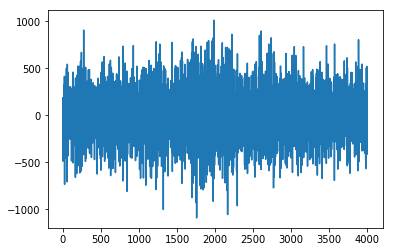

In [12]:
# reading the data
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
plt.plot(whale_array)

In [13]:
signal = whale_array.astype('float64')

In [14]:
# playing a whale upcall in the notebook
from IPython.display import Audio
Audio(signal, rate=3000, autoplay = True)# the rate is set to 3000 make the widget to run (seems the widget does not run with rate below 3000)

Working directly with the signals is hard (there is important frequency information). Let's calculate the spectrograms for each of the signals and use as features.

In [15]:
# a function for plotting spectrograms
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = pl.imshow(Z, extent=extent,cmap = 'plasma')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

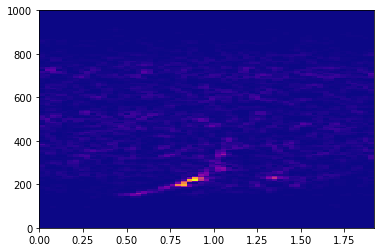

In [16]:
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

### Feature Extraction
---

We will go through all the files and extract the spectrograms from each of them.

In [17]:
# create a dictionary which contains all the spectrograms, labeled by the filename
spec_dict = {}

# threshold to cut higher frequencies
m = 60

# loop through all the files
for filename in filenames[:10000]:
    # read the file
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    # create the spectrogram
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P[:m,:]

# save the dimensions of the spectrogram
spec_dim = P[:m,:].shape
print(spec_dim)
    

(60, 59)


Most machine learning algorithms in Python expect the data to come in a format **observations** x **features**. In order to get the data in this format we need to convert the two-dimensional spectrogram into a long vector. For that we will use the `ravel` function.

In [18]:
# We will put the data in a dictionary
feature_dict = {}
for key in filenames[:10000]:
    # vectorize the spectrogram
    feature_dict[key.split('/')[-1]] = spec_dict[key].ravel()

# convert to a pandas dataframe
X = pd.DataFrame(feature_dict).T

In [19]:
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539
train1.aiff,0.133811,0.072258,0.109525,0.084067,0.139019,0.091778,0.259104,0.067828,0.111568,0.091280,...,323.757739,177.865058,69.035604,236.470513,95.348852,45.818186,62.494202,58.682033,27.582614,13.677962
train10.aiff,0.101112,0.105327,0.118087,0.106027,0.104224,0.115363,0.116329,0.111022,0.102463,0.105526,...,77.537118,7.339299,69.757836,54.389880,81.012734,2.399510,14.907799,194.893004,1055.685617,383.559875
train100.aiff,0.159426,0.009249,0.064405,0.092125,0.111605,0.106825,0.077956,0.136878,0.082509,0.145334,...,64.246441,43.523201,50.605585,134.076104,127.378906,19.264930,63.095352,91.668694,44.140122,19.513839
train1000.aiff,0.106400,0.110950,0.123805,0.118475,0.096641,0.087669,0.095947,0.089358,0.096594,0.106780,...,65.479278,441.932057,17.409286,344.068850,100.341791,16.224383,43.713053,215.872826,214.335619,32.082017
train10000.aiff,0.103849,0.098737,0.104135,0.106811,0.096488,0.094973,0.107081,0.119909,0.176325,0.141851,...,51.716674,47.501228,5.281048,2.434147,43.518454,49.159634,21.885118,24.566779,43.563790,60.620892


In [20]:
# we do not need these objects anymore so let's release them from memory
del feature_dict
del spec_dict

In [21]:
# let's save these variables for reuse
np.save('X.npy',X)
np.save('y.npy',np.array(labels['label'][X.index])[:10000])

### References:

https://www.kaggle.com/c/whale-detection-challenge

https://github.com/jaimeps/whale-sound-classification